In [1]:
# For vast.ai
# !git clone https://github.com/sobiodum/quantumai2.git
# !pip3 install --no-cache-dir -r requirements.txt

In [51]:
import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt
import time
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import joblib
import numpy as np
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from env.flo_portfolio import FlorianPortfolioEnv
from env.portfolio_multi_reward import FlorianPortfolioEnvMultiReward
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import ProgressBarCallback,CallbackList, EvalCallback
from models.callbacks import CustomCallBack, HParamCallback, TensorboardCallback
from models.models import DRLAgent
from gymnasium import spaces
from pyfolio import timeseries
import pyfolio
from plot.plot import convert_daily_return_to_pyfolio_ts, convert_account_value_to_pyfolio_ts, get_baseline, backtest_stats, get_daily_return
from hyperoptimizer.optunaoptimizer import optimize_optuna, optimize_optuna_FlorianPortfolioEnvMultiReward

In [3]:
df = pd.read_csv('SPX_2.csv', skiprows=6).dropna(axis=0)
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,MA20,tic
1,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,349.39,SPX
2,1990-01-04,355.67,358.74,352.89,358.76,58.72,61.98,56.59,332.52,344.49,349.69,SPX
3,1990-01-05,352.20,355.65,351.35,355.67,52.64,58.36,35.17,332.83,344.66,349.88,SPX
4,1990-01-08,353.79,352.19,350.54,354.24,54.94,59.48,48.55,333.16,344.89,350.19,SPX
5,1990-01-09,349.62,353.83,349.61,354.17,48.31,55.43,26.79,333.45,345.12,350.23,SPX
...,...,...,...,...,...,...,...,...,...,...,...,...
8450,2023-07-19,4565.72,4563.87,4557.48,4578.43,75.00,67.61,94.86,4043.67,4311.72,4435.98,SPX
8451,2023-07-20,4534.87,4554.38,4527.56,4564.74,67.94,64.81,53.04,4048.41,4319.65,4444.44,SPX
8452,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,4452.17,SPX
8453,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,4462.48,SPX


In [4]:
train_start = "1990-01-03"
train_end = "2015-12-31"
validate_start = "2016-01-01"
validate_end = "2020-12-31"
test_start = "2016-01-01"
test_end = "2023-07-25"

In [33]:
def data_split(df, start, end, target_date_col="date"):
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data

In [41]:
train = data_split(df, train_start, train_end)
validate = data_split(df, validate_start, validate_end)
train_df = train
train_df

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,MA20,tic
0,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,349.39,SPX
1,1990-01-04,355.67,358.74,352.89,358.76,58.72,61.98,56.59,332.52,344.49,349.69,SPX
2,1990-01-05,352.20,355.65,351.35,355.67,52.64,58.36,35.17,332.83,344.66,349.88,SPX
3,1990-01-08,353.79,352.19,350.54,354.24,54.94,59.48,48.55,333.16,344.89,350.19,SPX
4,1990-01-09,349.62,353.83,349.61,354.17,48.31,55.43,26.79,333.45,345.12,350.23,SPX
...,...,...,...,...,...,...,...,...,...,...,...,...
6546,2015-12-23,2064.29,2042.20,2042.20,2064.73,52.24,51.51,72.60,2061.50,2063.15,2057.30,SPX
6547,2015-12-24,2060.99,2063.52,2058.73,2067.36,51.57,51.17,67.81,2061.48,2064.48,2055.91,SPX
6548,2015-12-28,2056.50,2057.77,2044.20,2057.77,50.62,50.71,59.76,2061.49,2065.14,2054.23,SPX
6549,2015-12-29,2078.36,2060.54,2060.54,2081.56,54.96,52.85,78.45,2061.48,2066.04,2054.12,SPX


In [7]:
# stock_dimension = len(train.tic.unique())
# state_space = stock_dimension

In [35]:
train

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,MA20,tic
0,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,349.39,SPX
1,1990-01-04,355.67,358.74,352.89,358.76,58.72,61.98,56.59,332.52,344.49,349.69,SPX
2,1990-01-05,352.20,355.65,351.35,355.67,52.64,58.36,35.17,332.83,344.66,349.88,SPX
3,1990-01-08,353.79,352.19,350.54,354.24,54.94,59.48,48.55,333.16,344.89,350.19,SPX
4,1990-01-09,349.62,353.83,349.61,354.17,48.31,55.43,26.79,333.45,345.12,350.23,SPX
...,...,...,...,...,...,...,...,...,...,...,...,...
6546,2015-12-23,2064.29,2042.20,2042.20,2064.73,52.24,51.51,72.60,2061.50,2063.15,2057.30,SPX
6547,2015-12-24,2060.99,2063.52,2058.73,2067.36,51.57,51.17,67.81,2061.48,2064.48,2055.91,SPX
6548,2015-12-28,2056.50,2057.77,2044.20,2057.77,50.62,50.71,59.76,2061.49,2065.14,2054.23,SPX
6549,2015-12-29,2078.36,2060.54,2060.54,2081.56,54.96,52.85,78.45,2061.48,2066.04,2054.12,SPX


In [8]:
stock_list = train.tic.unique()
stock_list = stock_list.tolist()

In [9]:
indicators = ['RSI14', 'RSI30', 'RSI3','MA200', 'MA50', 'MA20']
stock_dimension = len(train.tic.unique())
state_space = 1+2*stock_dimension + len(indicators)
additional_price_info= ['open', 'low', 'high']
env_kwargs = {
    "initial_amount": 1000000, 
    "trade_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "stock_list": stock_list,
    "indicators": indicators, 
    "action_space": stock_dimension,
    "sharpe_ratio_weight": 0.1, #! to fine tune
    "loss_penalty_weight": 0.1, #! to fine tune
    "short_selling_allowed": True,
    "take_leverage_allowed": True,
    "reward_scaling": 0.00022786244568524788, # the magnitude of rewards can significantly affect the learning process. If the rewards are too large, they can cause the learning algorithm to become unstable. On the other hand, if the rewards are too small, the agent might not learn effectively because the rewards don't provide a strong enough signal.
    "hmax": 100, #! Fine tune
    # Not for optimization
    "make_plots": False,
    "num_stock_shares": [0], #number of initioal shares
    "model_name": "A-2C",
    "mode": "training", #can be anything, just for plots
    "iteration": "1000"#can be anything, just for plots
    
}




In [10]:

best_kwargs = {
    'learning_rate': 0.00033286121728969784, 
    'n_steps': 4323, 
    'gamma': 0.9936290127775395, 
    'gae_lambda': 0.9278567210820339, 
    'ent_coef': 0.026456032771495535, 
    'vf_coef': 0.13422186269360714, 
    'max_grad_norm': 0.20075683668791203, 
    'reward_scaling': 6.994468092813741e-05, 
    'short_selling_allowed': False, 
    'take_leverage_allowed': False
    }

best_kwargs_2 = {
    "learning_rate": 8.129895404502722e-05,
    "n_steps": 1963,
    # "total_timesteps": 13332,
    "gamma": 0.9397975225298403,
    "gae_lambda": 0.9506776772576876,
    "ent_coef": 0.023630640628023298,
    "vf_coef": 0.17576363274940895,
    "max_grad_norm": 0.21362181690007082,
    # "reward_scaling": 0.00022786244568524788,
    # "short_selling_allowed": False,
    # "take_leverage_allowed": True,

}



In [11]:
#initate env
e_train_gym = FlorianPortfolioEnvMultiReward(df=train, **env_kwargs)
e_validate_gym = FlorianPortfolioEnvMultiReward(df=validate, **env_kwargs)
env_train, _ = e_train_gym.get_env()
env_train = VecNormalize(env_train)
env_validate, _ = e_validate_gym.get_env()
env_validate = VecNormalize(env_validate)
print(type(env_train))

<class 'stable_baselines3.common.vec_env.vec_normalize.VecNormalize'>


In [12]:
#EvalCallback: Evaluate periodically the performance of an agent, using a separate test environment. It will save the best model if best_model_save_path folder is specified and save the evaluations results in a numpy archive (evaluations.npz) if log_path folder is specified.
eval_callback = EvalCallback(eval_env=env_train, best_model_save_path="./logs/", eval_freq=500, deterministic=True, render=False)
progress_callback = ProgressBarCallback()
params_callback = HParamCallback()


In [13]:
#Chaining Callbacks
callbacks = CallbackList([eval_callback,progress_callback, params_callback ])

In [14]:


study = optimize_optuna_FlorianPortfolioEnvMultiReward(env_train, env_validate, callbacks=None, n_trial_runs=20)

[I 2023-08-01 23:07:27,160] A new study created in memory with name: no-name-231602da-4a23-4bb9-b697-02f30f782c34


Trial 0 started.
day: 6550, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 8251066.38
total_reward: 7251066.38
total_cost: 443357.79
total_trades: 6506
Sharpe: 0.434
day: 6550, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 16142154.50
total_reward: 15142154.50
total_cost: 433689.01
total_trades: 6494
Sharpe: 0.471
day: 6550, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 4859630.25
total_reward: 3859630.25
total_cost: 440213.29
total_trades: 6498
Sharpe: 0.474
day: 6550, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 10959828.25
total_reward: 9959828.25
total_cost: 434308.38
total_trades: 6491
Sharpe: 0.459
day: 6550, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 13605549.00
total_reward: 12605549.00
total_cost: 436258.50
total_trades: 6491
Sharpe: 0.477
day: 6550, episode: 60
begin_total_asset: 1000000.00
end_total_asset: -4660513.00
total_reward: -5660513.00
total_cost: 443447.16
total_trades: 6503
Sharpe: -0.056
day: 6550

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 6310110.06
total_reward: 5310110.06
total_cost: 3522.87
total_trades: 3169
Sharpe: 0.443


[I 2023-08-01 23:14:09,053] Trial 0 finished with value: 36.01409012929889 and parameters: {'learning_rate': 6.0785919212677724e-05, 'n_steps': 7112, 'total_timesteps': 489452, 'gamma': 0.9730406409948886, 'gae_lambda': 0.9570494026701726, 'ent_coef': 0.011666342647424631, 'vf_coef': 0.1542670589608944, 'max_grad_norm': 0.34725972021891005, 'reward_scaling': 1.6203432769135537e-05, 'hmax': 36406, 'sharpe_ratio_weight': 0.21823875643746024, 'loss_penalty_weight': 0.19500892386981306}. Best is trial 0 with value: 36.01409012929889.


Trial 0 took 401.8876349925995 seconds.
Trial 1 started.
day: 6550, episode: 90
begin_total_asset: 1000000.00
end_total_asset: 13776451.00
total_reward: 12776451.00
total_cost: 436824.71
total_trades: 6499
Sharpe: 0.212
day: 6550, episode: 100
begin_total_asset: 1000000.00
end_total_asset: 3998646.25
total_reward: 2998646.25
total_cost: 432322.89
total_trades: 6502
Sharpe: 0.409
day: 6550, episode: 110
begin_total_asset: 1000000.00
end_total_asset: -1212726.50
total_reward: -2212726.50
total_cost: 441308.30
total_trades: 6497
Sharpe: 0.427
day: 6550, episode: 120
begin_total_asset: 1000000.00
end_total_asset: 767974.25
total_reward: -232025.75
total_cost: 437961.83
total_trades: 6487
Sharpe: 0.021
day: 6550, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 4605017.00
total_reward: 3605017.00
total_cost: 442450.14
total_trades: 6487
Sharpe: 0.439
day: 6550, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 1105426.50
total_reward: 105426.50
total_cost: 446077.71
tot

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 230
begin_total_asset: 1000000.00
end_total_asset: 1623270.75
total_reward: 623270.75
total_cost: 179.20
total_trades: 389
Sharpe: 0.341


[I 2023-08-01 23:25:30,588] Trial 1 finished with value: 6.96072676991737 and parameters: {'learning_rate': 1.5303099346381452e-05, 'n_steps': 5311, 'total_timesteps': 882146, 'gamma': 0.9466870389517802, 'gae_lambda': 0.9412688269966375, 'ent_coef': 0.09542573268006876, 'vf_coef': 0.23307224462386425, 'max_grad_norm': 0.3881413974167049, 'reward_scaling': 3.866144618115242e-05, 'hmax': 37598, 'sharpe_ratio_weight': 0.17071659547366672, 'loss_penalty_weight': 0.5473772612916246}. Best is trial 0 with value: 36.01409012929889.


Trial 1 took 681.5268061161041 seconds.
Trial 2 started.
day: 6550, episode: 240
begin_total_asset: 1000000.00
end_total_asset: -1424356.00
total_reward: -2424356.00
total_cost: 441111.63
total_trades: 6505
Sharpe: 0.199
day: 6550, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 3807072.00
total_reward: 2807072.00
total_cost: 441576.62
total_trades: 6505
Sharpe: 0.470
day: 6550, episode: 260
begin_total_asset: 1000000.00
end_total_asset: 4323815.62
total_reward: 3323815.62
total_cost: 446991.14
total_trades: 6501
Sharpe: 0.475
day: 6550, episode: 270
begin_total_asset: 1000000.00
end_total_asset: 12184132.00
total_reward: 11184132.00
total_cost: 447547.21
total_trades: 6505
Sharpe: 0.521
day: 6550, episode: 280
begin_total_asset: 1000000.00
end_total_asset: -8339649.00
total_reward: -9339649.00
total_cost: 441025.98
total_trades: 6491
Sharpe: 0.112
day: 6550, episode: 290
begin_total_asset: 1000000.00
end_total_asset: 669181.00
total_reward: -330819.00
total_cost: 442937.05

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 390
begin_total_asset: 1000000.00
end_total_asset: 39982628.00
total_reward: 38982628.00
total_cost: 54431.03
total_trades: 6550
Sharpe: -0.232


[I 2023-08-01 23:38:12,832] Trial 2 finished with value: 75.19089185962645 and parameters: {'learning_rate': 9.698317026685089e-05, 'n_steps': 7632, 'total_timesteps': 994883, 'gamma': 0.9878436033372934, 'gae_lambda': 0.9737208523347525, 'ent_coef': 0.080132656887017, 'vf_coef': 0.14840156814951927, 'max_grad_norm': 0.12765923674440965, 'reward_scaling': 5.129645648160282e-05, 'hmax': 45264, 'sharpe_ratio_weight': 0.8260694861402673, 'loss_penalty_weight': 0.18264877444247005}. Best is trial 2 with value: 75.19089185962645.


Trial 2 took 762.235533952713 seconds.
Trial 3 started.
day: 6550, episode: 400
begin_total_asset: 1000000.00
end_total_asset: -1515770.75
total_reward: -2515770.75
total_cost: 433587.99
total_trades: 6508
Sharpe: 0.034
day: 6550, episode: 410
begin_total_asset: 1000000.00
end_total_asset: -895155.50
total_reward: -1895155.50
total_cost: 438996.10
total_trades: 6503
Sharpe: -0.177
day: 6550, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 7399927.50
total_reward: 6399927.50
total_cost: 439570.10
total_trades: 6512
Sharpe: 0.194
day: 6550, episode: 430
begin_total_asset: 1000000.00
end_total_asset: 2826675.00
total_reward: 1826675.00
total_cost: 440723.91
total_trades: 6499
Sharpe: -0.066
day: 6550, episode: 440
begin_total_asset: 1000000.00
end_total_asset: 5479066.50
total_reward: 4479066.50
total_cost: 441114.99
total_trades: 6511
Sharpe: 0.516
day: 6550, episode: 450
begin_total_asset: 1000000.00
end_total_asset: 11344387.00
total_reward: 10344387.00
total_cost: 446466.5

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 500
begin_total_asset: 1000000.00
end_total_asset: 1248694.38
total_reward: 248694.38
total_cost: 4041.49
total_trades: 3171
Sharpe: 0.131


[I 2023-08-01 23:46:29,701] Trial 3 finished with value: 1.1475730295281026 and parameters: {'learning_rate': 2.654520578074807e-05, 'n_steps': 2999, 'total_timesteps': 608858, 'gamma': 0.9841842629453489, 'gae_lambda': 0.9121663905645623, 'ent_coef': 0.014816225592242814, 'vf_coef': 0.1756894362879214, 'max_grad_norm': 0.15784959402496862, 'reward_scaling': 5.8163501903319455e-05, 'hmax': 34478, 'sharpe_ratio_weight': 0.17845516439483716, 'loss_penalty_weight': 0.6445001493622514}. Best is trial 2 with value: 75.19089185962645.


Trial 3 took 496.8541328907013 seconds.
Trial 4 started.
day: 6550, episode: 510
begin_total_asset: 1000000.00
end_total_asset: 869532.00
total_reward: -130468.00
total_cost: 439419.30
total_trades: 6488
Sharpe: 0.356
day: 6550, episode: 520
begin_total_asset: 1000000.00
end_total_asset: 1245526.25
total_reward: 245526.25
total_cost: 440299.55
total_trades: 6502
Sharpe: 0.151
day: 6550, episode: 530
begin_total_asset: 1000000.00
end_total_asset: 5901067.75
total_reward: 4901067.75
total_cost: 442325.61
total_trades: 6495
Sharpe: 0.440
day: 6550, episode: 540
begin_total_asset: 1000000.00
end_total_asset: -1007756.00
total_reward: -2007756.00
total_cost: 438963.66
total_trades: 6497
Sharpe: -0.075
day: 6550, episode: 550
begin_total_asset: 1000000.00
end_total_asset: 7382787.50
total_reward: 6382787.50
total_cost: 446397.74
total_trades: 6499
Sharpe: 0.388
day: 6550, episode: 560
begin_total_asset: 1000000.00
end_total_asset: -3183358.00
total_reward: -4183358.00
total_cost: 435863.95
t

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 620
begin_total_asset: 1000000.00
end_total_asset: -518367.50
total_reward: -1518367.50
total_cost: 3788.25
total_trades: 2570
Sharpe: 0.159


[I 2023-08-01 23:56:12,645] Trial 4 finished with value: 1.160179685745954 and parameters: {'learning_rate': 4.613483474129554e-05, 'n_steps': 9118, 'total_timesteps': 724499, 'gamma': 0.9152602926604212, 'gae_lambda': 0.961743394766621, 'ent_coef': 0.04305950079769043, 'vf_coef': 0.22502679984928936, 'max_grad_norm': 0.11194542026164626, 'reward_scaling': 0.00023785098037888117, 'hmax': 12080, 'sharpe_ratio_weight': 0.5780104273681302, 'loss_penalty_weight': 0.31663441141055476}. Best is trial 2 with value: 75.19089185962645.


Trial 4 took 582.9278440475464 seconds.
Trial 5 started.
day: 6550, episode: 630
begin_total_asset: 1000000.00
end_total_asset: 3112626.00
total_reward: 2112626.00
total_cost: 444545.16
total_trades: 6489
Sharpe: -0.035
day: 6550, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 8469225.00
total_reward: 7469225.00
total_cost: 440365.41
total_trades: 6500
Sharpe: 0.436


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 650
begin_total_asset: 1000000.00
end_total_asset: 3367022.12
total_reward: 2367022.12
total_cost: 3568.38
total_trades: 3431
Sharpe: 0.448


[I 2023-08-01 23:58:28,827] Trial 5 finished with value: 6.72672820443847 and parameters: {'learning_rate': 3.348718879047262e-05, 'n_steps': 9975, 'total_timesteps': 121248, 'gamma': 0.9566775006212354, 'gae_lambda': 0.9903150484238491, 'ent_coef': 0.02001988639747169, 'vf_coef': 0.12304223625364834, 'max_grad_norm': 0.19250779987103214, 'reward_scaling': 0.0002641375278755747, 'hmax': 40096, 'sharpe_ratio_weight': 0.3962764778964637, 'loss_penalty_weight': 0.11552675350918039}. Best is trial 2 with value: 75.19089185962645.


Trial 5 took 136.17259764671326 seconds.
Trial 6 started.
day: 6550, episode: 660
begin_total_asset: 1000000.00
end_total_asset: 1021969.00
total_reward: 21969.00
total_cost: 440590.34
total_trades: 6495
Sharpe: 0.135
day: 6550, episode: 670
begin_total_asset: 1000000.00
end_total_asset: 8578236.00
total_reward: 7578236.00
total_cost: 450425.59
total_trades: 6499
Sharpe: 0.588
day: 6550, episode: 680
begin_total_asset: 1000000.00
end_total_asset: 7969660.75
total_reward: 6969660.75
total_cost: 441950.12
total_trades: 6495
Sharpe: -0.140
day: 6550, episode: 690
begin_total_asset: 1000000.00
end_total_asset: 2831900.00
total_reward: 1831900.00
total_cost: 438649.60
total_trades: 6499
Sharpe: 0.359
day: 6550, episode: 700
begin_total_asset: 1000000.00
end_total_asset: 17469217.00
total_reward: 16469217.00
total_cost: 442525.14
total_trades: 6492
Sharpe: 0.502


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 10860993.88
total_reward: 9860993.88
total_cost: 17992.53
total_trades: 5599
Sharpe: 0.588


[I 2023-08-02 00:02:41,974] Trial 6 finished with value: 29.84275820216925 and parameters: {'learning_rate': 5.077204062264215e-05, 'n_steps': 2296, 'total_timesteps': 279211, 'gamma': 0.9152024779559342, 'gae_lambda': 0.9961858655902963, 'ent_coef': 0.026910041068645717, 'vf_coef': 0.17099043712921175, 'max_grad_norm': 0.1178805359663389, 'reward_scaling': 0.0009682344706776651, 'hmax': 7939, 'sharpe_ratio_weight': 0.20212157657985438, 'loss_penalty_weight': 0.22710786263044977}. Best is trial 2 with value: 75.19089185962645.


Trial 6 took 253.1395719051361 seconds.
Trial 7 started.
day: 6550, episode: 720
begin_total_asset: 1000000.00
end_total_asset: 7261997.75
total_reward: 6261997.75
total_cost: 440713.75
total_trades: 6498
Sharpe: 0.479
day: 6550, episode: 730
begin_total_asset: 1000000.00
end_total_asset: 2756965.50
total_reward: 1756965.50
total_cost: 442899.34
total_trades: 6478
Sharpe: 0.141
day: 6550, episode: 740
begin_total_asset: 1000000.00
end_total_asset: 14257730.00
total_reward: 13257730.00
total_cost: 437070.47
total_trades: 6492
Sharpe: 0.101
day: 6550, episode: 750
begin_total_asset: 1000000.00
end_total_asset: 27049241.00
total_reward: 26049241.00
total_cost: 439333.72
total_trades: 6501
Sharpe: 0.183
day: 6550, episode: 760
begin_total_asset: 1000000.00
end_total_asset: 6689334.50
total_reward: 5689334.50
total_cost: 449209.84
total_trades: 6508
Sharpe: 0.466
day: 6550, episode: 770
begin_total_asset: 1000000.00
end_total_asset: 30789178.00
total_reward: 29789178.00
total_cost: 439061.1

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 840
begin_total_asset: 1000000.00
end_total_asset: 9659306.69
total_reward: 8659306.69
total_cost: 17293.72
total_trades: 5206
Sharpe: 0.541


[I 2023-08-02 00:13:23,793] Trial 7 finished with value: 28.272673627555626 and parameters: {'learning_rate': 9.23911387761084e-05, 'n_steps': 6843, 'total_timesteps': 814198, 'gamma': 0.9394636357571955, 'gae_lambda': 0.9738511561130005, 'ent_coef': 0.05341136860361159, 'vf_coef': 0.1385502496050711, 'max_grad_norm': 0.32243338050407006, 'reward_scaling': 0.0002303644553662031, 'hmax': 28121, 'sharpe_ratio_weight': 0.6031099925408975, 'loss_penalty_weight': 0.10192756974209081}. Best is trial 2 with value: 75.19089185962645.


Trial 7 took 641.8109498023987 seconds.
Trial 8 started.
day: 6550, episode: 850
begin_total_asset: 1000000.00
end_total_asset: 7264334.00
total_reward: 6264334.00
total_cost: 442757.41
total_trades: 6506
Sharpe: -0.168
day: 6550, episode: 860
begin_total_asset: 1000000.00
end_total_asset: 6725655.00
total_reward: 5725655.00
total_cost: 440249.34
total_trades: 6477
Sharpe: 0.329
day: 6550, episode: 870
begin_total_asset: 1000000.00
end_total_asset: -11570006.50
total_reward: -12570006.50
total_cost: 443411.29
total_trades: 6499
Sharpe: 0.239


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 880
begin_total_asset: 1000000.00
end_total_asset: 1016574.96
total_reward: 16574.96
total_cost: 14.36
total_trades: 15
Sharpe: 0.264


[I 2023-08-02 00:16:16,798] Trial 8 finished with value: 0.06006278371151872 and parameters: {'learning_rate': 3.6115305099348816e-05, 'n_steps': 6200, 'total_timesteps': 172162, 'gamma': 0.9670636383038361, 'gae_lambda': 0.9586878219838859, 'ent_coef': 0.027773134478816738, 'vf_coef': 0.20330206314621252, 'max_grad_norm': 0.3025165242042571, 'reward_scaling': 0.000288473270365125, 'hmax': 7924, 'sharpe_ratio_weight': 0.13906655697177772, 'loss_penalty_weight': 0.819120660355345}. Best is trial 2 with value: 75.19089185962645.


Trial 8 took 172.9937288761139 seconds.
Trial 9 started.
day: 6550, episode: 890
begin_total_asset: 1000000.00
end_total_asset: -2496713.12
total_reward: -3496713.12
total_cost: 439051.43
total_trades: 6500
Sharpe: -0.354
day: 6550, episode: 900
begin_total_asset: 1000000.00
end_total_asset: -8348587.00
total_reward: -9348587.00
total_cost: 438276.77
total_trades: 6491
Sharpe: -0.173
day: 6550, episode: 910
begin_total_asset: 1000000.00
end_total_asset: 363546.50
total_reward: -636453.50
total_cost: 445464.83
total_trades: 6495
Sharpe: 0.118
day: 6550, episode: 920
begin_total_asset: 1000000.00
end_total_asset: 1151602.00
total_reward: 151602.00
total_cost: 443640.76
total_trades: 6507
Sharpe: 0.047


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 930
begin_total_asset: 1000000.00
end_total_asset: -6943063.38
total_reward: -7943063.38
total_cost: 8375.81
total_trades: 4403
Sharpe: 0.305


[I 2023-08-02 00:20:06,537] Trial 9 finished with value: 6.967228380698446 and parameters: {'learning_rate': 6.177203235638987e-05, 'n_steps': 1286, 'total_timesteps': 267365, 'gamma': 0.9546431879640526, 'gae_lambda': 0.9616688429957879, 'ent_coef': 0.07525051918611331, 'vf_coef': 0.20183524303290198, 'max_grad_norm': 0.3884301875915923, 'reward_scaling': 0.0006502550419305622, 'hmax': 7769, 'sharpe_ratio_weight': 0.1617644192132029, 'loss_penalty_weight': 0.291237377360942}. Best is trial 2 with value: 75.19089185962645.


Trial 9 took 229.72869205474854 seconds.
Trial 10 started.
day: 6550, episode: 940
begin_total_asset: 1000000.00
end_total_asset: 12779115.50
total_reward: 11779115.50
total_cost: 443793.21
total_trades: 6500
Sharpe: 0.520
day: 6550, episode: 950
begin_total_asset: 1000000.00
end_total_asset: -5588094.00
total_reward: -6588094.00
total_cost: 442240.10
total_trades: 6499
Sharpe: 0.227
day: 6550, episode: 960
begin_total_asset: 1000000.00
end_total_asset: -1108043.00
total_reward: -2108043.00
total_cost: 441337.22
total_trades: 6493
Sharpe: 0.328
day: 6550, episode: 970
begin_total_asset: 1000000.00
end_total_asset: -6558367.88
total_reward: -7558367.88
total_cost: 444712.62
total_trades: 6496
Sharpe: 0.209
day: 6550, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 1264222.00
total_reward: 264222.00
total_cost: 445067.30
total_trades: 6499
Sharpe: -0.271
day: 6550, episode: 990
begin_total_asset: 1000000.00
end_total_asset: 4255178.00
total_reward: 3255178.00
total_cost: 4447

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 1100
begin_total_asset: 1000000.00
end_total_asset: 27404076.00
total_reward: 26404076.00
total_cost: 64644.10
total_trades: 6122
Sharpe: -0.152


[I 2023-08-02 00:32:53,498] Trial 10 finished with value: 91.7834652324747 and parameters: {'learning_rate': 7.969209505298883e-05, 'n_steps': 4465, 'total_timesteps': 998904, 'gamma': 0.9993628651591083, 'gae_lambda': 0.9360155234406123, 'ent_coef': 0.05752812006185739, 'vf_coef': 0.10479177002470984, 'max_grad_norm': 0.1025694743447065, 'reward_scaling': 1.891811427454211e-05, 'hmax': 49957, 'sharpe_ratio_weight': 0.8359008485980746, 'loss_penalty_weight': 0.17723213037637195}. Best is trial 10 with value: 91.7834652324747.


Trial 10 took 766.944121837616 seconds.
Trial 11 started.
day: 6550, episode: 1110
begin_total_asset: 1000000.00
end_total_asset: -5526080.00
total_reward: -6526080.00
total_cost: 442622.45
total_trades: 6504
Sharpe: -0.133
day: 6550, episode: 1120
begin_total_asset: 1000000.00
end_total_asset: -2983731.00
total_reward: -3983731.00
total_cost: 441572.71
total_trades: 6490
Sharpe: -0.230
day: 6550, episode: 1130
begin_total_asset: 1000000.00
end_total_asset: 841924.50
total_reward: -158075.50
total_cost: 434193.23
total_trades: 6497
Sharpe: 0.429
day: 6550, episode: 1140
begin_total_asset: 1000000.00
end_total_asset: -39779024.00
total_reward: -40779024.00
total_cost: 448801.49
total_trades: 6487
Sharpe: -0.242
day: 6550, episode: 1150
begin_total_asset: 1000000.00
end_total_asset: 3150488.25
total_reward: 2150488.25
total_cost: 440882.56
total_trades: 6501
Sharpe: 0.299
day: 6550, episode: 1160
begin_total_asset: 1000000.00
end_total_asset: -25704272.00
total_reward: -26704272.00
total

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 1260
begin_total_asset: 1000000.00
end_total_asset: -69790624.00
total_reward: -70790624.00
total_cost: 92711.96
total_trades: 6550
Sharpe: -0.290


[I 2023-08-02 00:45:38,903] Trial 11 finished with value: 40.4026316421924 and parameters: {'learning_rate': 9.400838336807951e-05, 'n_steps': 4515, 'total_timesteps': 973716, 'gamma': 0.9984460266578046, 'gae_lambda': 0.9349250089954958, 'ent_coef': 0.0611701200679527, 'vf_coef': 0.10528105383260336, 'max_grad_norm': 0.10452593091867558, 'reward_scaling': 1.4813364969356144e-05, 'hmax': 48624, 'sharpe_ratio_weight': 0.862467129313649, 'loss_penalty_weight': 0.15297771113313788}. Best is trial 10 with value: 91.7834652324747.


Trial 11 took 765.2885150909424 seconds.
Trial 12 started.
day: 6550, episode: 1270
begin_total_asset: 1000000.00
end_total_asset: 6526984.00
total_reward: 5526984.00
total_cost: 444911.39
total_trades: 6504
Sharpe: 0.168
day: 6550, episode: 1280
begin_total_asset: 1000000.00
end_total_asset: -1509895.00
total_reward: -2509895.00
total_cost: 438217.21
total_trades: 6484
Sharpe: -0.343
day: 6550, episode: 1290
begin_total_asset: 1000000.00
end_total_asset: 10239562.00
total_reward: 9239562.00
total_cost: 441538.27
total_trades: 6509
Sharpe: -0.077
day: 6550, episode: 1300
begin_total_asset: 1000000.00
end_total_asset: 7655229.00
total_reward: 6655229.00
total_cost: 443256.98
total_trades: 6499
Sharpe: 0.464
day: 6550, episode: 1310
begin_total_asset: 1000000.00
end_total_asset: -6734428.69
total_reward: -7734428.69
total_cost: 444644.16
total_trades: 6507
Sharpe: 0.190
day: 6550, episode: 1320
begin_total_asset: 1000000.00
end_total_asset: 7948466.38
total_reward: 6948466.38
total_cost:

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 1420
begin_total_asset: 1000000.00
end_total_asset: 56773648.00
total_reward: 55773648.00
total_cost: 81174.95
total_trades: 6549
Sharpe: 0.298


[I 2023-08-02 00:58:10,707] Trial 12 finished with value: 77.6819732820657 and parameters: {'learning_rate': 9.928215174666997e-05, 'n_steps': 7737, 'total_timesteps': 994508, 'gamma': 0.9985062722302133, 'gae_lambda': 0.9301203202550544, 'ent_coef': 0.09595765690149448, 'vf_coef': 0.10021133279023069, 'max_grad_norm': 0.13445606329264517, 'reward_scaling': 2.9718062753248218e-05, 'hmax': 49879, 'sharpe_ratio_weight': 0.8440437049445879, 'loss_penalty_weight': 0.15506846854392378}. Best is trial 10 with value: 91.7834652324747.


Trial 12 took 751.7178630828857 seconds.
Trial 13 started.
day: 6550, episode: 1430
begin_total_asset: 1000000.00
end_total_asset: -4330292.00
total_reward: -5330292.00
total_cost: 437637.52
total_trades: 6493
Sharpe: 0.197
day: 6550, episode: 1440
begin_total_asset: 1000000.00
end_total_asset: -3796193.00
total_reward: -4796193.00
total_cost: 442085.90
total_trades: 6504
Sharpe: 0.283
day: 6550, episode: 1450
begin_total_asset: 1000000.00
end_total_asset: 1675656.12
total_reward: 675656.12
total_cost: 438299.01
total_trades: 6500
Sharpe: 0.199
day: 6550, episode: 1460
begin_total_asset: 1000000.00
end_total_asset: 2722006.69
total_reward: 1722006.69
total_cost: 442902.40
total_trades: 6496
Sharpe: 0.275
day: 6550, episode: 1470
begin_total_asset: 1000000.00
end_total_asset: 14307444.00
total_reward: 13307444.00
total_cost: 441331.25
total_trades: 6503
Sharpe: 0.593
day: 6550, episode: 1480
begin_total_asset: 1000000.00
end_total_asset: 11278280.50
total_reward: 10278280.50
total_cost:

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 1540
begin_total_asset: 1000000.00
end_total_asset: 14385901.50
total_reward: 13385901.50
total_cost: 21320.36
total_trades: 5611
Sharpe: 0.455


[I 2023-08-02 01:07:37,838] Trial 13 finished with value: 18.027489837959486 and parameters: {'learning_rate': 7.499061841210482e-05, 'n_steps': 4628, 'total_timesteps': 718764, 'gamma': 0.9975387317088348, 'gae_lambda': 0.9238575936814046, 'ent_coef': 0.09778488286631365, 'vf_coef': 0.1009592454892112, 'max_grad_norm': 0.1005980343624965, 'reward_scaling': 1.1943213553731262e-05, 'hmax': 18065, 'sharpe_ratio_weight': 0.37465556790581916, 'loss_penalty_weight': 0.13500162856472694}. Best is trial 10 with value: 91.7834652324747.


Trial 13 took 567.1135900020599 seconds.
Trial 14 started.
day: 6550, episode: 1550
begin_total_asset: 1000000.00
end_total_asset: 9815155.50
total_reward: 8815155.50
total_cost: 442363.02
total_trades: 6493
Sharpe: 0.028
day: 6550, episode: 1560
begin_total_asset: 1000000.00
end_total_asset: 8610685.00
total_reward: 7610685.00
total_cost: 435691.00
total_trades: 6508
Sharpe: 0.581
day: 6550, episode: 1570
begin_total_asset: 1000000.00
end_total_asset: -4731135.00
total_reward: -5731135.00
total_cost: 442041.50
total_trades: 6511
Sharpe: 0.206
day: 6550, episode: 1580
begin_total_asset: 1000000.00
end_total_asset: 15706455.00
total_reward: 14706455.00
total_cost: 441145.23
total_trades: 6502
Sharpe: -0.239
day: 6550, episode: 1590
begin_total_asset: 1000000.00
end_total_asset: -1364207.00
total_reward: -2364207.00
total_cost: 437631.29
total_trades: 6474
Sharpe: 0.062
day: 6550, episode: 1600
begin_total_asset: 1000000.00
end_total_asset: 404471.06
total_reward: -595528.94
total_cost: 

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 1630
begin_total_asset: 1000000.00
end_total_asset: -345516.73
total_reward: -1345516.73
total_cost: 1841.07
total_trades: 1750
Sharpe: 0.242


[I 2023-08-02 01:14:08,170] Trial 14 finished with value: 0.47364091076581394 and parameters: {'learning_rate': 7.053102607211066e-05, 'n_steps': 8164, 'total_timesteps': 471764, 'gamma': 0.980116857686616, 'gae_lambda': 0.9004667786931506, 'ent_coef': 0.04227726277768556, 'vf_coef': 0.12079733342027171, 'max_grad_norm': 0.1385911325194624, 'reward_scaling': 2.638239730106889e-05, 'hmax': 49401, 'sharpe_ratio_weight': 0.6228793253537165, 'loss_penalty_weight': 0.14384180826218182}. Best is trial 10 with value: 91.7834652324747.


Trial 14 took 390.3108158111572 seconds.
Trial 15 started.
day: 6550, episode: 1640
begin_total_asset: 1000000.00
end_total_asset: 17538584.00
total_reward: 16538584.00
total_cost: 439343.43
total_trades: 6515
Sharpe: 0.465
day: 6550, episode: 1650
begin_total_asset: 1000000.00
end_total_asset: 2357828.00
total_reward: 1357828.00
total_cost: 442232.09
total_trades: 6500
Sharpe: 0.261
day: 6550, episode: 1660
begin_total_asset: 1000000.00
end_total_asset: 10118469.00
total_reward: 9118469.00
total_cost: 448149.26
total_trades: 6506
Sharpe: 0.031
day: 6550, episode: 1670
begin_total_asset: 1000000.00
end_total_asset: 4873660.53
total_reward: 3873660.53
total_cost: 438620.67
total_trades: 6493
Sharpe: 0.428
day: 6550, episode: 1680
begin_total_asset: 1000000.00
end_total_asset: 6338764.12
total_reward: 5338764.12
total_cost: 441804.49
total_trades: 6493
Sharpe: 0.527
day: 6550, episode: 1690
begin_total_asset: 1000000.00
end_total_asset: 27386640.00
total_reward: 26386640.00
total_cost: 4

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 1770
begin_total_asset: 1000000.00
end_total_asset: 66090552.00
total_reward: 65090552.00
total_cost: 68881.12
total_trades: 6468
Sharpe: -0.127


[I 2023-08-02 01:25:27,832] Trial 15 finished with value: 86.94360271761661 and parameters: {'learning_rate': 7.510237571788497e-05, 'n_steps': 3524, 'total_timesteps': 863849, 'gamma': 0.9974910960032304, 'gae_lambda': 0.9299301367046158, 'ent_coef': 0.06391260931577024, 'vf_coef': 0.2843890459913521, 'max_grad_norm': 0.15406168927589822, 'reward_scaling': 2.4481121025375568e-05, 'hmax': 26146, 'sharpe_ratio_weight': 0.10313422524117448, 'loss_penalty_weight': 0.10008966484338833}. Best is trial 10 with value: 91.7834652324747.


Trial 15 took 679.6479649543762 seconds.
Trial 16 started.
day: 6550, episode: 1780
begin_total_asset: 1000000.00
end_total_asset: 1994642.12
total_reward: 994642.12
total_cost: 440254.45
total_trades: 6500
Sharpe: 0.259
day: 6550, episode: 1790
begin_total_asset: 1000000.00
end_total_asset: 14758561.00
total_reward: 13758561.00
total_cost: 438583.70
total_trades: 6492
Sharpe: 0.534
day: 6550, episode: 1800
begin_total_asset: 1000000.00
end_total_asset: -6796160.88
total_reward: -7796160.88
total_cost: 437555.70
total_trades: 6500
Sharpe: -0.296
day: 6550, episode: 1810
begin_total_asset: 1000000.00
end_total_asset: 9793514.00
total_reward: 8793514.00
total_cost: 444651.87
total_trades: 6504
Sharpe: 0.005
day: 6550, episode: 1820
begin_total_asset: 1000000.00
end_total_asset: 2473081.50
total_reward: 1473081.50
total_cost: 441538.24
total_trades: 6494
Sharpe: 0.192
day: 6550, episode: 1830
begin_total_asset: 1000000.00
end_total_asset: -8976449.50
total_reward: -9976449.50
total_cost: 

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 1910
begin_total_asset: 1000000.00
end_total_asset: 2338345.31
total_reward: 1338345.31
total_cost: 10088.48
total_trades: 4699
Sharpe: 0.321


[I 2023-08-02 01:36:14,634] Trial 16 finished with value: 1.6148733694458866 and parameters: {'learning_rate': 4.531122826280232e-05, 'n_steps': 3711, 'total_timesteps': 840675, 'gamma': 0.9697875846453788, 'gae_lambda': 0.946804190541404, 'ent_coef': 0.060538456485041435, 'vf_coef': 0.29103103839537475, 'max_grad_norm': 0.16259723078962462, 'reward_scaling': 1.0183462078733455e-05, 'hmax': 25338, 'sharpe_ratio_weight': 0.11638240344954674, 'loss_penalty_weight': 0.1019132101246504}. Best is trial 10 with value: 91.7834652324747.


Trial 16 took 646.7870907783508 seconds.
Trial 17 started.
day: 6550, episode: 1920
begin_total_asset: 1000000.00
end_total_asset: 12268072.00
total_reward: 11268072.00
total_cost: 444514.02
total_trades: 6507
Sharpe: 0.131
day: 6550, episode: 1930
begin_total_asset: 1000000.00
end_total_asset: 695514.00
total_reward: -304486.00
total_cost: 442836.79
total_trades: 6496
Sharpe: 0.189
day: 6550, episode: 1940
begin_total_asset: 1000000.00
end_total_asset: 2495384.75
total_reward: 1495384.75
total_cost: 446580.47
total_trades: 6494
Sharpe: 0.359
day: 6550, episode: 1950
begin_total_asset: 1000000.00
end_total_asset: -16249792.00
total_reward: -17249792.00
total_cost: 444791.56
total_trades: 6504
Sharpe: -0.051
day: 6550, episode: 1960
begin_total_asset: 1000000.00
end_total_asset: 10538127.00
total_reward: 9538127.00
total_cost: 442254.79
total_trades: 6490
Sharpe: -0.003
day: 6550, episode: 1970
begin_total_asset: 1000000.00
end_total_asset: -2260651.50
total_reward: -3260651.50
total_co

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 2020
begin_total_asset: 1000000.00
end_total_asset: -8277309.00
total_reward: -9277309.00
total_cost: 17031.66
total_trades: 5350
Sharpe: 0.109


[I 2023-08-02 01:44:53,164] Trial 17 finished with value: 3.6305511891835947 and parameters: {'learning_rate': 7.2499671615592e-05, 'n_steps': 3313, 'total_timesteps': 663594, 'gamma': 0.9896774718868862, 'gae_lambda': 0.9218432728379516, 'ent_coef': 0.038079270451169864, 'vf_coef': 0.2737389158214267, 'max_grad_norm': 0.2334115078287615, 'reward_scaling': 8.389185860931098e-05, 'hmax': 21298, 'sharpe_ratio_weight': 0.26758342656567746, 'loss_penalty_weight': 0.1242862122686351}. Best is trial 10 with value: 91.7834652324747.


Trial 17 took 518.5193862915039 seconds.
Trial 18 started.
day: 6550, episode: 2030
begin_total_asset: 1000000.00
end_total_asset: -1036341.62
total_reward: -2036341.62
total_cost: 437482.50
total_trades: 6497
Sharpe: 0.019
day: 6550, episode: 2040
begin_total_asset: 1000000.00
end_total_asset: -9831509.00
total_reward: -10831509.00
total_cost: 444509.30
total_trades: 6495
Sharpe: 0.242
day: 6550, episode: 2050
begin_total_asset: 1000000.00
end_total_asset: 5866687.50
total_reward: 4866687.50
total_cost: 436963.65
total_trades: 6494
Sharpe: -0.203
day: 6550, episode: 2060
begin_total_asset: 1000000.00
end_total_asset: 840038.00
total_reward: -159962.00
total_cost: 447704.24
total_trades: 6509
Sharpe: 0.347
day: 6550, episode: 2070
begin_total_asset: 1000000.00
end_total_asset: 8280559.75
total_reward: 7280559.75
total_cost: 434953.58
total_trades: 6480
Sharpe: 0.213
day: 6550, episode: 2080
begin_total_asset: 1000000.00
end_total_asset: 5948538.00
total_reward: 4948538.00
total_cost: 4

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 2170
begin_total_asset: 1000000.00
end_total_asset: 2242013.88
total_reward: 1242013.88
total_cost: 3861.74
total_trades: 3359
Sharpe: 0.395


[I 2023-08-02 01:56:18,879] Trial 18 finished with value: 1.7414875851176177 and parameters: {'learning_rate': 2.4810986819385868e-05, 'n_steps': 2398, 'total_timesteps': 889372, 'gamma': 0.977903854095381, 'gae_lambda': 0.9413853873076721, 'ent_coef': 0.05058649411410095, 'vf_coef': 0.24624570240390314, 'max_grad_norm': 0.12058775640360783, 'reward_scaling': 2.1533678394800393e-05, 'hmax': 30503, 'sharpe_ratio_weight': 0.11973188602732711, 'loss_penalty_weight': 0.10053342349788279}. Best is trial 10 with value: 91.7834652324747.


Trial 18 took 685.7015748023987 seconds.
Trial 19 started.
day: 6550, episode: 2180
begin_total_asset: 1000000.00
end_total_asset: 4922160.38
total_reward: 3922160.38
total_cost: 436344.92
total_trades: 6493
Sharpe: 0.346
day: 6550, episode: 2190
begin_total_asset: 1000000.00
end_total_asset: 939636.00
total_reward: -60364.00
total_cost: 443402.02
total_trades: 6483
Sharpe: 0.051
day: 6550, episode: 2200
begin_total_asset: 1000000.00
end_total_asset: -2251409.69
total_reward: -3251409.69
total_cost: 443087.28
total_trades: 6503
Sharpe: -0.099
day: 6550, episode: 2210
begin_total_asset: 1000000.00
end_total_asset: 5010363.00
total_reward: 4010363.00
total_cost: 446812.64
total_trades: 6504
Sharpe: 0.356
day: 6550, episode: 2220
begin_total_asset: 1000000.00
end_total_asset: -10720299.00
total_reward: -11720299.00
total_cost: 444708.24
total_trades: 6495
Sharpe: -0.046
day: 6550, episode: 2230
begin_total_asset: 1000000.00
end_total_asset: 5727705.25
total_reward: 4727705.25
total_cost: 

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 6550, episode: 2300
begin_total_asset: 1000000.00
end_total_asset: -11947557.00
total_reward: -12947557.00
total_cost: 36757.06
total_trades: 5941
Sharpe: 0.225


[I 2023-08-02 02:06:46,173] Trial 19 finished with value: 4.233389666414699 and parameters: {'learning_rate': 5.5469223418164e-05, 'n_steps': 1109, 'total_timesteps': 777462, 'gamma': 0.9889754314985251, 'gae_lambda': 0.9341058849333618, 'ent_coef': 0.03586087103515846, 'vf_coef': 0.29164808129750447, 'max_grad_norm': 0.10077368909419882, 'reward_scaling': 2.2642807788767145e-05, 'hmax': 15195, 'sharpe_ratio_weight': 0.27422742018756685, 'loss_penalty_weight': 0.1770254328933363}. Best is trial 10 with value: 91.7834652324747.


Trial 19 took 627.2722413539886 seconds.
Best trial:
Value: 91.7834652324747
Best hyperparameters:
    learning_rate: 7.969209505298883e-05
    n_steps: 4465
    total_timesteps: 998904
    gamma: 0.9993628651591083
    gae_lambda: 0.9360155234406123
    ent_coef: 0.05752812006185739
    vf_coef: 0.10479177002470984
    max_grad_norm: 0.1025694743447065
    reward_scaling: 1.891811427454211e-05
    hmax: 49957
    sharpe_ratio_weight: 0.8359008485980746
    loss_penalty_weight: 0.17723213037637195


In [15]:
optuna.visualization.plot_optimization_history(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study)

Wandb

In [22]:
import os
import wandb

os.environ["WANDB_API_KEY"] = "7f0155c08333a1cd3fc2bfaae555cd38344b421d"
wandb.login()

wandb: Currently logged in as: kocklerf. Use `wandb login --relogin` to force relogin


True

In [23]:
sweep_config = {
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'cumulative_reward',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 0.00001,
            'max': 0.0001
        },
        'n_steps': {
            'min': 1000,
            'max': 10000
        },
        'hmax': {
            'min': 1000,
            'max': 50000
        },
        

            "gamma": {
            'min': 0.9,
            'max': 0.9999
            },
            "gae_lambda": {
                'min': 0.9,
            'max': 1.0
            },
            "ent_coef": {
                   'min': 0.01,
            'max': 0.1
            },
            "vf_coef": {
                        'min': 0.1,
            'max': 0.3
            },
            "max_grad_norm": {
                  'min': 0.1,
            'max': 0.4
            },
            "reward_scaling": {
                    'min': 1e-5,
            'max': 1e-3
            },
            "sharpe_ratio_weight": {
                    'min': 0.1,
            'max': 0.95
            },
            "loss_penalty_weight": {
                    'min': 0.1,
            'max': 0.95
            }
     
        
        # fill the rest of your hyperparameters
    }
}

In [39]:
train

<function __main__.train()>

In [42]:
stock_list = ["SPX"]

indicators = ['RSI14', 'RSI30', 'RSI3','MA200', 'MA50', 'MA20']
stock_dimension = 1
state_space = 1+2*stock_dimension + len(indicators)
additional_price_info= ['open', 'low', 'high']
remaining_kwargs = {
    "initial_amount": 1000000, 
    "trade_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "stock_list": stock_list,
    "indicators": indicators, 
    "action_space": stock_dimension,
    "short_selling_allowed": True,
    "take_leverage_allowed": True,
    # Not for optimization
    "make_plots": False,
    "num_stock_shares": [0], #number of initioal shares
    "model_name": "A-2C",
    "mode": "training", #can be anything, just for plots
    "iteration": "1000"#can be anything, just for plots
    
}
def train():
    # Initialize a new wandb run
    run = wandb.init()

    # Get hyperparameters from the config
    config = wandb.config



    e_train_gym_wandb = FlorianPortfolioEnvMultiReward(df=train_df,reward_scaling=config.reward_scaling, hmax=config.hmax, sharpe_ratio_weight=config.sharpe_ratio_weight, loss_penalty_weight=config.loss_penalty_weight, **remaining_kwargs)
    env_train, _ = e_train_gym_wandb.get_env()
    env_train = VecNormalize(env_train)

    # Create and train the model
    model = A2C('MlpPolicy', env_train, verbose=0, tensorboard_log="./tensorboard/a2c_florian/", learning_rate=config.learning_rate, n_steps=config.n_steps, gamma=config.gamma, gae_lambda=config.gae_lambda, ent_coef=config.ent_coef, vf_coef=config.vf_coef, max_grad_norm=config.max_grad_norm)
    try:
        model.learn(total_timesteps=500000, callback=WandbCallback())
    except Exception as e:
        wandb.log({"run_error": str(e)})
        run.finish()
        return

    # Save the model
    os.makedirs("/wanddb_models/", exist_ok=True)
    model.save(f"/wanddb_models/model_{run.id}")

    # Close the run
    run.finish()

In [ ]:
try:
    sweep_id = wandb.sweep(sweep_config, project="portfolio1")
    wandb.agent(sweep_id, train)
except AttributeError as e:
    print(f"Caught an AttributeError: {e}")
    print("Additional information for debugging...")

Create sweep with ID: czaj9w6j
Sweep URL: https://wandb.ai/kocklerf/portfolio1/sweeps/czaj9w6j


wandb: Agent Starting Run: 5d6ttpv1 with config:
wandb: 	ent_coef: 0.06301810443088943
wandb: 	gae_lambda: 0.9589052615925304
wandb: 	gamma: 0.9397418759198451
wandb: 	hmax: 42542
wandb: 	learning_rate: 9.193479636818764e-05
wandb: 	loss_penalty_weight: 0.2858715928854416
wandb: 	max_grad_norm: 0.241312622125426
wandb: 	n_steps: 6560
wandb: 	reward_scaling: 0.0005181960768701476
wandb: 	sharpe_ratio_weight: 0.4757612296781384
wandb: 	vf_coef: 0.1966920760054968


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: x9qu3xvo with config:
wandb: 	ent_coef: 0.09132086201600964
wandb: 	gae_lambda: 0.9538658009990733
wandb: 	gamma: 0.9968739741802312
wandb: 	hmax: 11664
wandb: 	learning_rate: 3.1569860403897484e-05
wandb: 	loss_penalty_weight: 0.5127434051008123
wandb: 	max_grad_norm: 0.29714762557255076
wandb: 	n_steps: 5774
wandb: 	reward_scaling: 0.0006568994838626257
wandb: 	sharpe_ratio_weight: 0.13753475333692472
wandb: 	vf_coef: 0.2973684996678124


run_error,name 'WandbCallback'...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0jvfyv1w with config:
wandb: 	ent_coef: 0.06861399701478225
wandb: 	gae_lambda: 0.9760322115443916
wandb: 	gamma: 0.9225821156751408
wandb: 	hmax: 37373
wandb: 	learning_rate: 1.4443436080663442e-05
wandb: 	loss_penalty_weight: 0.22621324511318264
wandb: 	max_grad_norm: 0.26701836767675113
wandb: 	n_steps: 1796
wandb: 	reward_scaling: 0.00029562797642076615
wandb: 	sharpe_ratio_weight: 0.16933336113111186
wandb: 	vf_coef: 0.20189716679166275


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 80owc0bo with config:
wandb: 	ent_coef: 0.039872077772754595
wandb: 	gae_lambda: 0.9110090687085458
wandb: 	gamma: 0.94223663226449
wandb: 	hmax: 11425
wandb: 	learning_rate: 7.270606658276815e-05
wandb: 	loss_penalty_weight: 0.5274224612479103
wandb: 	max_grad_norm: 0.28067618869330413
wandb: 	n_steps: 5637
wandb: 	reward_scaling: 0.0001935433176438937
wandb: 	sharpe_ratio_weight: 0.7220678953491061
wandb: 	vf_coef: 0.1530166918385588


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: pmotxnbu with config:
wandb: 	ent_coef: 0.0521758647371805
wandb: 	gae_lambda: 0.912717308966882
wandb: 	gamma: 0.9156792515490092
wandb: 	hmax: 44646
wandb: 	learning_rate: 3.5350835957717896e-05
wandb: 	loss_penalty_weight: 0.6041302092097174
wandb: 	max_grad_norm: 0.16144757563349826
wandb: 	n_steps: 9168
wandb: 	reward_scaling: 0.0002808855624019369
wandb: 	sharpe_ratio_weight: 0.48966670493972153
wandb: 	vf_coef: 0.17693024843039673


run_error,name 'WandbCallback'...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iudqwgvw with config:
wandb: 	ent_coef: 0.0913392247104671
wandb: 	gae_lambda: 0.9628120063207818
wandb: 	gamma: 0.9393683029523966
wandb: 	hmax: 15533
wandb: 	learning_rate: 9.985812400102988e-05
wandb: 	loss_penalty_weight: 0.21541823222200177
wandb: 	max_grad_norm: 0.3740268071582703
wandb: 	n_steps: 4536
wandb: 	reward_scaling: 0.0007387774998408565
wandb: 	sharpe_ratio_weight: 0.6221565237986785
wandb: 	vf_coef: 0.2721784629072225


run_error,name 'WandbCallback'...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4m48miy2 with config:
wandb: 	ent_coef: 0.03473763802937228
wandb: 	gae_lambda: 0.955615178939576
wandb: 	gamma: 0.959513020611478
wandb: 	hmax: 42731
wandb: 	learning_rate: 3.852353533881288e-05
wandb: 	loss_penalty_weight: 0.6235911172692687
wandb: 	max_grad_norm: 0.1921784883443212
wandb: 	n_steps: 5020
wandb: 	reward_scaling: 0.00012409305915143633
wandb: 	sharpe_ratio_weight: 0.6412829168087006
wandb: 	vf_coef: 0.1382383719473808


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: vln1jpd9 with config:
wandb: 	ent_coef: 0.021838257042970575
wandb: 	gae_lambda: 0.9456119247511152
wandb: 	gamma: 0.9460501259551204
wandb: 	hmax: 7670
wandb: 	learning_rate: 1.846798605061954e-05
wandb: 	loss_penalty_weight: 0.26664142685033343
wandb: 	max_grad_norm: 0.3876975701407117
wandb: 	n_steps: 2635
wandb: 	reward_scaling: 8.582720216952395e-05
wandb: 	sharpe_ratio_weight: 0.8731829154399934
wandb: 	vf_coef: 0.20078912701118415


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 1hoy124d with config:
wandb: 	ent_coef: 0.01674734387735381
wandb: 	gae_lambda: 0.9510421196694012
wandb: 	gamma: 0.970276065909758
wandb: 	hmax: 47149
wandb: 	learning_rate: 1.1146330795674698e-05
wandb: 	loss_penalty_weight: 0.9022174487430756
wandb: 	max_grad_norm: 0.31455846460750203
wandb: 	n_steps: 4311
wandb: 	reward_scaling: 0.0009097116220956112
wandb: 	sharpe_ratio_weight: 0.5042101555780948
wandb: 	vf_coef: 0.1968355166431166


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: kjrkkpov with config:
wandb: 	ent_coef: 0.03329186381012408
wandb: 	gae_lambda: 0.9887992778484158
wandb: 	gamma: 0.9705319774273548
wandb: 	hmax: 13667
wandb: 	learning_rate: 5.011148945615796e-05
wandb: 	loss_penalty_weight: 0.5870199954812708
wandb: 	max_grad_norm: 0.31451224401975714
wandb: 	n_steps: 3770
wandb: 	reward_scaling: 0.0007560864658337317
wandb: 	sharpe_ratio_weight: 0.7450752965580978
wandb: 	vf_coef: 0.21732061346212067


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 0im3juu5 with config:
wandb: 	ent_coef: 0.0820443325531014
wandb: 	gae_lambda: 0.9604399746778524
wandb: 	gamma: 0.9870894695833512
wandb: 	hmax: 16723
wandb: 	learning_rate: 7.320356490446753e-05
wandb: 	loss_penalty_weight: 0.4154471879648485
wandb: 	max_grad_norm: 0.31361665082012136
wandb: 	n_steps: 4710
wandb: 	reward_scaling: 0.0005243979132630519
wandb: 	sharpe_ratio_weight: 0.4249739848426624
wandb: 	vf_coef: 0.12970967483430693


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: onua9vw4 with config:
wandb: 	ent_coef: 0.01598632619151446
wandb: 	gae_lambda: 0.9714553357674764
wandb: 	gamma: 0.9097206889339255
wandb: 	hmax: 24087
wandb: 	learning_rate: 7.862714337321897e-05
wandb: 	loss_penalty_weight: 0.456643201016568
wandb: 	max_grad_norm: 0.3859268365226687
wandb: 	n_steps: 4628
wandb: 	reward_scaling: 0.0007456094785308786
wandb: 	sharpe_ratio_weight: 0.16448712760692802
wandb: 	vf_coef: 0.16588720355071518


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: ra9dkh97 with config:
wandb: 	ent_coef: 0.04981291533136623
wandb: 	gae_lambda: 0.9817860134744696
wandb: 	gamma: 0.9877088684057008
wandb: 	hmax: 41365
wandb: 	learning_rate: 3.416505096977289e-05
wandb: 	loss_penalty_weight: 0.23503867436311007
wandb: 	max_grad_norm: 0.39706938210485576
wandb: 	n_steps: 2532
wandb: 	reward_scaling: 0.0004133426945163923
wandb: 	sharpe_ratio_weight: 0.6880475687512345
wandb: 	vf_coef: 0.21230643370214264


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: iv5be231 with config:
wandb: 	ent_coef: 0.07689869196118394
wandb: 	gae_lambda: 0.998517965051301
wandb: 	gamma: 0.9755819026621716
wandb: 	hmax: 34018
wandb: 	learning_rate: 2.758389907382778e-05
wandb: 	loss_penalty_weight: 0.891483690258069
wandb: 	max_grad_norm: 0.20027699319466696
wandb: 	n_steps: 1517
wandb: 	reward_scaling: 2.104745105186373e-05
wandb: 	sharpe_ratio_weight: 0.1972245769878412
wandb: 	vf_coef: 0.2559442655945875


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 5i16k0fe with config:
wandb: 	ent_coef: 0.03736081189220956
wandb: 	gae_lambda: 0.9458202818679646
wandb: 	gamma: 0.950054994941859
wandb: 	hmax: 6799
wandb: 	learning_rate: 2.5621840903496924e-05
wandb: 	loss_penalty_weight: 0.4449718024524085
wandb: 	max_grad_norm: 0.17344439653564123
wandb: 	n_steps: 1194
wandb: 	reward_scaling: 1.5154491041160906e-05
wandb: 	sharpe_ratio_weight: 0.19226510097580385
wandb: 	vf_coef: 0.20064235632715408


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 257k0z2a with config:
wandb: 	ent_coef: 0.07909438714643845
wandb: 	gae_lambda: 0.960485258680432
wandb: 	gamma: 0.9467555997270732
wandb: 	hmax: 26810
wandb: 	learning_rate: 8.528104611494269e-05
wandb: 	loss_penalty_weight: 0.4438404426159501
wandb: 	max_grad_norm: 0.2911941888838109
wandb: 	n_steps: 4979
wandb: 	reward_scaling: 0.0008339553844435871
wandb: 	sharpe_ratio_weight: 0.5479923209596755
wandb: 	vf_coef: 0.2300890582572725


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: vmqn4xhf with config:
wandb: 	ent_coef: 0.04788127519405656
wandb: 	gae_lambda: 0.905049943879786
wandb: 	gamma: 0.9636527899980016
wandb: 	hmax: 6948
wandb: 	learning_rate: 5.42557189837712e-05
wandb: 	loss_penalty_weight: 0.4320594498813003
wandb: 	max_grad_norm: 0.36236750484399616
wandb: 	n_steps: 2282
wandb: 	reward_scaling: 0.0004527629253842128
wandb: 	sharpe_ratio_weight: 0.17190237114794812
wandb: 	vf_coef: 0.102591708380276


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 6p2weijn with config:
wandb: 	ent_coef: 0.04484827406580193
wandb: 	gae_lambda: 0.9974849423124132
wandb: 	gamma: 0.9229891247391436
wandb: 	hmax: 18568
wandb: 	learning_rate: 4.418219609893133e-05
wandb: 	loss_penalty_weight: 0.1146256939250272
wandb: 	max_grad_norm: 0.36794061137605505
wandb: 	n_steps: 5066
wandb: 	reward_scaling: 5.3268381151524214e-05
wandb: 	sharpe_ratio_weight: 0.4846656880167367
wandb: 	vf_coef: 0.15809550723080537


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 4crpvkgl with config:
wandb: 	ent_coef: 0.0717902527757185
wandb: 	gae_lambda: 0.9182318637510712
wandb: 	gamma: 0.9118478168224534
wandb: 	hmax: 45538
wandb: 	learning_rate: 1.4844355147064288e-05
wandb: 	loss_penalty_weight: 0.6934156670296192
wandb: 	max_grad_norm: 0.2749883118319753
wandb: 	n_steps: 3814
wandb: 	reward_scaling: 9.525017854428512e-05
wandb: 	sharpe_ratio_weight: 0.285943184587071
wandb: 	vf_coef: 0.29965672887329275


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: ccfbxlz5 with config:
wandb: 	ent_coef: 0.01609123078835988
wandb: 	gae_lambda: 0.9811606014338612
wandb: 	gamma: 0.9749817783778716
wandb: 	hmax: 2169
wandb: 	learning_rate: 7.754200753614682e-05
wandb: 	loss_penalty_weight: 0.4674136729774129
wandb: 	max_grad_norm: 0.29524620378565825
wandb: 	n_steps: 9351
wandb: 	reward_scaling: 0.00010183450085253932
wandb: 	sharpe_ratio_weight: 0.5625867286811624
wandb: 	vf_coef: 0.2372368452469862


run_error,name 'WandbCallback'...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8e38qm52 with config:
wandb: 	ent_coef: 0.01149030599919768
wandb: 	gae_lambda: 0.9535292460089
wandb: 	gamma: 0.959458077881108
wandb: 	hmax: 13820
wandb: 	learning_rate: 5.21597512259118e-05
wandb: 	loss_penalty_weight: 0.3023936975364818
wandb: 	max_grad_norm: 0.381609330887406
wandb: 	n_steps: 3065
wandb: 	reward_scaling: 0.0007829534701973677
wandb: 	sharpe_ratio_weight: 0.1287434607624867
wandb: 	vf_coef: 0.15578921055568945


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: djlu2s5t with config:
wandb: 	ent_coef: 0.039771739562476614
wandb: 	gae_lambda: 0.9358035033185796
wandb: 	gamma: 0.971129849843267
wandb: 	hmax: 49370
wandb: 	learning_rate: 8.198076208761919e-05
wandb: 	loss_penalty_weight: 0.2461013821421432
wandb: 	max_grad_norm: 0.20870193012358823
wandb: 	n_steps: 1044
wandb: 	reward_scaling: 0.0002196222148273184
wandb: 	sharpe_ratio_weight: 0.5843592204442019
wandb: 	vf_coef: 0.2728253819590253


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: c9r2l1rt with config:
wandb: 	ent_coef: 0.017373249785263504
wandb: 	gae_lambda: 0.9511626579480452
wandb: 	gamma: 0.901651654648998
wandb: 	hmax: 39722
wandb: 	learning_rate: 7.372076275661147e-05
wandb: 	loss_penalty_weight: 0.586100386706545
wandb: 	max_grad_norm: 0.34379644805140674
wandb: 	n_steps: 2140
wandb: 	reward_scaling: 0.0005213390022711867
wandb: 	sharpe_ratio_weight: 0.2687043029336681
wandb: 	vf_coef: 0.26596464451435164


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 3gbsk2ye with config:
wandb: 	ent_coef: 0.02874927535061643
wandb: 	gae_lambda: 0.9996192236627024
wandb: 	gamma: 0.9992582850822356
wandb: 	hmax: 5523
wandb: 	learning_rate: 2.89644169098371e-05
wandb: 	loss_penalty_weight: 0.8981877725120763
wandb: 	max_grad_norm: 0.17304220343035698
wandb: 	n_steps: 5785
wandb: 	reward_scaling: 0.0001229589448648211
wandb: 	sharpe_ratio_weight: 0.21035623499483688
wandb: 	vf_coef: 0.28015946885384246


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: ohz77nfb with config:
wandb: 	ent_coef: 0.05189224594685157
wandb: 	gae_lambda: 0.9977489628541883
wandb: 	gamma: 0.985234990774048
wandb: 	hmax: 22724
wandb: 	learning_rate: 8.941053035445096e-05
wandb: 	loss_penalty_weight: 0.21391893262435052
wandb: 	max_grad_norm: 0.19832730119282133
wandb: 	n_steps: 5143
wandb: 	reward_scaling: 2.110993138172836e-05
wandb: 	sharpe_ratio_weight: 0.37031280759017415
wandb: 	vf_coef: 0.21034184072370776


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: wxey4qcf with config:
wandb: 	ent_coef: 0.09819065994564438
wandb: 	gae_lambda: 0.9016272432320752
wandb: 	gamma: 0.9450419860443402
wandb: 	hmax: 24596
wandb: 	learning_rate: 9.541644400145268e-05
wandb: 	loss_penalty_weight: 0.8928943389979193
wandb: 	max_grad_norm: 0.2072803355123349
wandb: 	n_steps: 3033
wandb: 	reward_scaling: 0.0007226517152314765
wandb: 	sharpe_ratio_weight: 0.48502557944239955
wandb: 	vf_coef: 0.23998500425515296


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: bsm4lb8l with config:
wandb: 	ent_coef: 0.016020379348436774
wandb: 	gae_lambda: 0.9266453180563956
wandb: 	gamma: 0.9898370950159638
wandb: 	hmax: 35230
wandb: 	learning_rate: 3.378359453816205e-05
wandb: 	loss_penalty_weight: 0.20215970785887505
wandb: 	max_grad_norm: 0.30370435901850956
wandb: 	n_steps: 2140
wandb: 	reward_scaling: 0.0001935120182258932
wandb: 	sharpe_ratio_weight: 0.6075056874761484
wandb: 	vf_coef: 0.14647085865986065


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: 5zdilkcr with config:
wandb: 	ent_coef: 0.08309493759187972
wandb: 	gae_lambda: 0.9160760797492667
wandb: 	gamma: 0.9405729611329288
wandb: 	hmax: 21450
wandb: 	learning_rate: 6.581011163040713e-05
wandb: 	loss_penalty_weight: 0.6977125502729878
wandb: 	max_grad_norm: 0.12281712546683116
wandb: 	n_steps: 8834
wandb: 	reward_scaling: 0.0007226504028095404
wandb: 	sharpe_ratio_weight: 0.8457429753619067
wandb: 	vf_coef: 0.20041596320813715


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: kaxqpfzq with config:
wandb: 	ent_coef: 0.08602346588169461
wandb: 	gae_lambda: 0.90122111910556
wandb: 	gamma: 0.9514452584377407
wandb: 	hmax: 8965
wandb: 	learning_rate: 3.4389094818954946e-05
wandb: 	loss_penalty_weight: 0.4083907199745648
wandb: 	max_grad_norm: 0.3332083859130143
wandb: 	n_steps: 3648
wandb: 	reward_scaling: 0.0006403071473085802
wandb: 	sharpe_ratio_weight: 0.3486388208561813
wandb: 	vf_coef: 0.11175194086423593


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: n53mzfqu with config:
wandb: 	ent_coef: 0.012288425942260924
wandb: 	gae_lambda: 0.9836359731667969
wandb: 	gamma: 0.9303486569103476
wandb: 	hmax: 16730
wandb: 	learning_rate: 5.158954138503163e-05
wandb: 	loss_penalty_weight: 0.1995371047705456
wandb: 	max_grad_norm: 0.3379350877826467
wandb: 	n_steps: 5491
wandb: 	reward_scaling: 0.000732150934228092
wandb: 	sharpe_ratio_weight: 0.8047350950940001
wandb: 	vf_coef: 0.19622353463743175


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: sulpjnn5 with config:
wandb: 	ent_coef: 0.05005169000816152
wandb: 	gae_lambda: 0.9896750656528216
wandb: 	gamma: 0.9576602308762406
wandb: 	hmax: 10529
wandb: 	learning_rate: 8.337219865542905e-05
wandb: 	loss_penalty_weight: 0.25344224570213647
wandb: 	max_grad_norm: 0.3389577542521929
wandb: 	n_steps: 5205
wandb: 	reward_scaling: 0.0009448455388770128
wandb: 	sharpe_ratio_weight: 0.5632542587406852
wandb: 	vf_coef: 0.23360607229969735


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: w3hgv17u with config:
wandb: 	ent_coef: 0.02622307515072695
wandb: 	gae_lambda: 0.9613127146919072
wandb: 	gamma: 0.9097775635448816
wandb: 	hmax: 42194
wandb: 	learning_rate: 6.42739983167695e-05
wandb: 	loss_penalty_weight: 0.22579403561115824
wandb: 	max_grad_norm: 0.2334997424242203
wandb: 	n_steps: 8345
wandb: 	reward_scaling: 4.7861181889369887e-05
wandb: 	sharpe_ratio_weight: 0.5241904849629857
wandb: 	vf_coef: 0.1726845678642463


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: uvx03nmc with config:
wandb: 	ent_coef: 0.01693403571107457
wandb: 	gae_lambda: 0.912546578725852
wandb: 	gamma: 0.9621519493338596
wandb: 	hmax: 49913
wandb: 	learning_rate: 3.267302559631948e-05
wandb: 	loss_penalty_weight: 0.7457552067353228
wandb: 	max_grad_norm: 0.19044836240725924
wandb: 	n_steps: 3996
wandb: 	reward_scaling: 0.00037960151019344936
wandb: 	sharpe_ratio_weight: 0.21915569369440668
wandb: 	vf_coef: 0.2814743474042595


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: md0mckum with config:
wandb: 	ent_coef: 0.09285772491166087
wandb: 	gae_lambda: 0.9652805408593752
wandb: 	gamma: 0.952315944406224
wandb: 	hmax: 12091
wandb: 	learning_rate: 5.619515707484409e-05
wandb: 	loss_penalty_weight: 0.5933416609584935
wandb: 	max_grad_norm: 0.3973970995636706
wandb: 	n_steps: 8733
wandb: 	reward_scaling: 0.0001777986520915672
wandb: 	sharpe_ratio_weight: 0.7482610580385263
wandb: 	vf_coef: 0.2646060887694587


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: az5k3jph with config:
wandb: 	ent_coef: 0.06668998614392944
wandb: 	gae_lambda: 0.9943332117220284
wandb: 	gamma: 0.9346173774174892
wandb: 	hmax: 45538
wandb: 	learning_rate: 2.5836577653043e-05
wandb: 	loss_penalty_weight: 0.48882470828074864
wandb: 	max_grad_norm: 0.2246022061533226
wandb: 	n_steps: 7405
wandb: 	reward_scaling: 0.0009557635728513528
wandb: 	sharpe_ratio_weight: 0.5808896835312231
wandb: 	vf_coef: 0.2574236037378478


run_error,name 'WandbCallback'...


wandb: Agent Starting Run: s01cli8i with config:
wandb: 	ent_coef: 0.05333943723119312
wandb: 	gae_lambda: 0.9685684418138456
wandb: 	gamma: 0.943354120917294
wandb: 	hmax: 42659
wandb: 	learning_rate: 3.206312572093273e-05
wandb: 	loss_penalty_weight: 0.949541303619105
wandb: 	max_grad_norm: 0.3245324947320687
wandb: 	n_steps: 4727
wandb: 	reward_scaling: 6.716199224005446e-05
wandb: 	sharpe_ratio_weight: 0.934214604074902
wandb: 	vf_coef: 0.13713604154830422
wandb: Ctrl + C detected. Stopping sweep.


run_error,name 'WandbCallback'...


In [19]:

#Define and Train the agend
# model = A2C('MlpPolicy', env, verbose=0, tensorboard_log="./tensorboard/a2c_florian/")
# model.learn(total_timesteps=50000, callback=callbacks, tb_log_name="a2c_florian_any_name")
# Once the learn function is called, you can monitor the RL agent during or after the training, with the following bash command:
# tensorboard --logdir ./a2c_cartpole_tensorboard/

In [20]:

model = A2C('MlpPolicy', env_train, verbose=0, tensorboard_log="./tensorboard/a2c_florian/", **best_kwargs_2)
trained_model = model.learn(total_timesteps=500000, callback=TensorboardCallback(), tb_log_name="a2c_florian_any_name")
# trained_model = model.learn(callback=None, tb_log_name="a2c_florian_any_name")


day: 6550, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2336629.12
total_reward: 1336629.12
total_cost: 434875.73
total_trades: 6500
Sharpe: 0.258
day: 6550, episode: 20
begin_total_asset: 1000000.00
end_total_asset: -2671558.69
total_reward: -3671558.69
total_cost: 439678.75
total_trades: 6498
Sharpe: -0.234
day: 6550, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 5500576.98
total_reward: 4500576.98
total_cost: 445200.05
total_trades: 6500
Sharpe: 0.448
day: 6550, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 2865608.30
total_reward: 1865608.30
total_cost: 443416.82
total_trades: 6510
Sharpe: 0.302
day: 6550, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 4602872.62
total_reward: 3602872.62
total_cost: 439846.78
total_trades: 6489
Sharpe: 0.408
day: 6550, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 4348302.55
total_reward: 3348302.55
total_cost: 435754.92
total_trades: 6492
Sharpe: 0.386
day: 6550, episode: 70
begin_to

In [35]:
# trained_model.save("test_model_outper_w_leverage")

In [22]:
# loaded_model = A2C.load("test_model_after_optuna")

In [45]:
best_model = A2C.load("best_model.zip")

In [46]:
e_test_gym = FlorianPortfolioEnvMultiReward(df=test_df, **env_kwargs)
env_test, _ = e_test_gym.get_env()
env_test = VecNormalize(env_validate)

Trading

In [54]:
test_df = data_split(df,test_start, test_end)
e_test_gym = FlorianPortfolioEnvMultiReward(df=test_df, **env_kwargs)
env_test, obs_test = e_test_gym.get_env()
env_test = VecNormalize(env_test)

In [57]:
df_account_memory, df_actions, df_daily_return, portfolio_memory_df = DRLAgent.DRL_prediction_flo(
    model=best_model,
    environment = e_test_gym
)

hit end!


In [59]:
portfolio_memory_df

,cash,SPX,date
0,1.000000e+06,0.0,2016-01-04
1,1.028149e+06,-14.0,2016-01-05
2,1.056355e+06,-28.0,2016-01-06
3,1.084190e+06,-42.0,2016-01-07
4,1.111366e+06,-56.0,2016-01-08
...,...,...,...
1896,8.546333e+07,-26544.0,2023-07-18
1897,8.552703e+07,-26558.0,2023-07-19
1898,8.559089e+07,-26572.0,2023-07-20
1899,8.565431e+07,-26586.0,2023-07-21


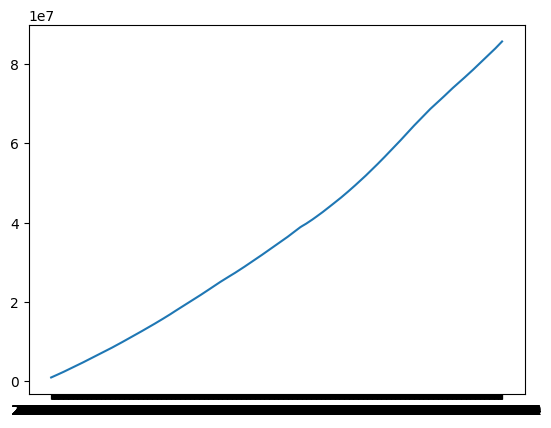

In [60]:
plt.plot(portfolio_memory_df['date'], portfolio_memory_df['cash'])

In [61]:
portfolio_memory_df["SPX"].max()

0.0

In [62]:
df_account_memory

,date,account_value
0,2016-01-04,1.000000e+06
1,2016-01-05,9.999151e+05
2,2016-01-06,1.000627e+06
3,2016-01-07,1.002581e+06
4,2016-01-08,1.003733e+06
...,...,...
1896,2023-07-18,-3.544406e+07
1897,2023-07-19,-3.572937e+07
1898,2023-07-20,-3.490968e+07
1899,2023-07-21,-3.494882e+07


In [63]:
df_daily_return

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,-0.000085
2,2016-01-06,0.000712
3,2016-01-07,0.001952
4,2016-01-08,0.001149
...,...,...
1896,2023-07-18,0.024705
1897,2023-07-19,0.008049
1898,2023-07-20,-0.022942
1899,2023-07-21,0.001121


In [64]:
df_actions

,date,actions
0,2016-01-04,[-14]
1,2016-01-05,[-14]
2,2016-01-06,[-14]
3,2016-01-07,[-14]
4,2016-01-08,[-14]
...,...,...
1895,2023-07-17,[-14]
1896,2023-07-18,[-14]
1897,2023-07-19,[-14]
1898,2023-07-20,[-14]


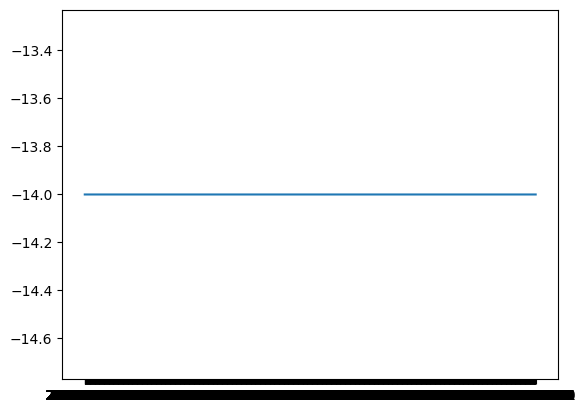

In [65]:
df_actions['actions'] = df_actions['actions'].apply(lambda x: x[0])
plt.plot(df_actions['date'], df_actions['actions'])

In [66]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/empyrical/stats.py:391: RuntimeWarning:

invalid value encountered in scalar power

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/empyrical/stats.py:391: RuntimeWarning:

invalid value encountered in scalar power

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/empyrical/stats.py:1380: RuntimeWarning:

invalid value encountered in log1p



In [67]:
DRL_strat

date
2016-01-04 00:00:00+00:00    0.000000
2016-01-05 00:00:00+00:00   -0.000085
2016-01-06 00:00:00+00:00    0.000712
2016-01-07 00:00:00+00:00    0.001952
2016-01-08 00:00:00+00:00    0.001149
                               ...   
2023-07-18 00:00:00+00:00    0.024705
2023-07-19 00:00:00+00:00    0.008049
2023-07-20 00:00:00+00:00   -0.022942
2023-07-21 00:00:00+00:00    0.001121
2023-07-24 00:00:00+00:00    0.013930
Length: 1901, dtype: float64

In [68]:
df_daily_return

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,-0.000085
2,2016-01-06,0.000712
3,2016-01-07,0.001952
4,2016-01-08,0.001149
...,...,...
1896,2023-07-18,0.024705
1897,2023-07-19,0.008049
1898,2023-07-20,-0.022942
1899,2023-07-21,0.001121


In [69]:
perf_stats_all

Annual return                   NaN
Cumulative returns    -3.643566e+01
Annual volatility      2.292616e+01
Sharpe ratio          -5.234097e-01
Calmar ratio                    NaN
Stability                       NaN
Max drawdown          -7.293395e+00
Omega ratio            5.324714e-01
Sortino ratio         -5.355440e-01
Skew                  -2.526487e+01
Kurtosis               7.189060e+02
Tail ratio             8.610203e-01
Daily value at risk   -2.936043e+00
Alpha                 -5.595524e-14
Beta                   1.000000e+00
dtype: float64

In [70]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^SPX", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1900, 8)
Annual return          0.113808
Cumulative returns     1.253903
Annual volatility      0.189534
Sharpe ratio           0.664305
Calmar ratio           0.335470
Stability              0.896539
Max drawdown          -0.339250
Omega ratio            1.140467
Sortino ratio          0.923685
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.902529
Daily value at risk   -0.023379
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1901, 8)


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/empyrical/stats.py:391: RuntimeWarning:

invalid value encountered in scalar power

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/empyrical/stats.py:391: RuntimeWarning:

invalid value encountered in scalar power

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/empyrical/stats.py:1380: RuntimeWarning:

invalid value encountered in log1p



Start date,2016-01-04
End date,2023-07-24
Total months,90
,Backtest
Annual return,nan%
Cumulative returns,-3643.566%
Annual volatility,2292.616%
Sharpe ratio,-0.52
Calmar ratio,NaN
Stability,NaN
Max drawdown,-729.339%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,729.34,2020-03-23,2022-01-03,NaT,NaN
1,704.04,2018-12-24,2020-02-19,2020-03-12,319
2,498.94,2016-02-11,2018-09-20,2018-12-21,747
3,139.00,2020-03-12,2020-03-13,2020-03-16,3
4,55.01,2020-03-16,2020-03-17,2020-03-20,5


Stress Events,mean,min,max
New Normal,-16.03%,-4415.95%,597.08%
Covid,1.10%,-503.05%,612.40%


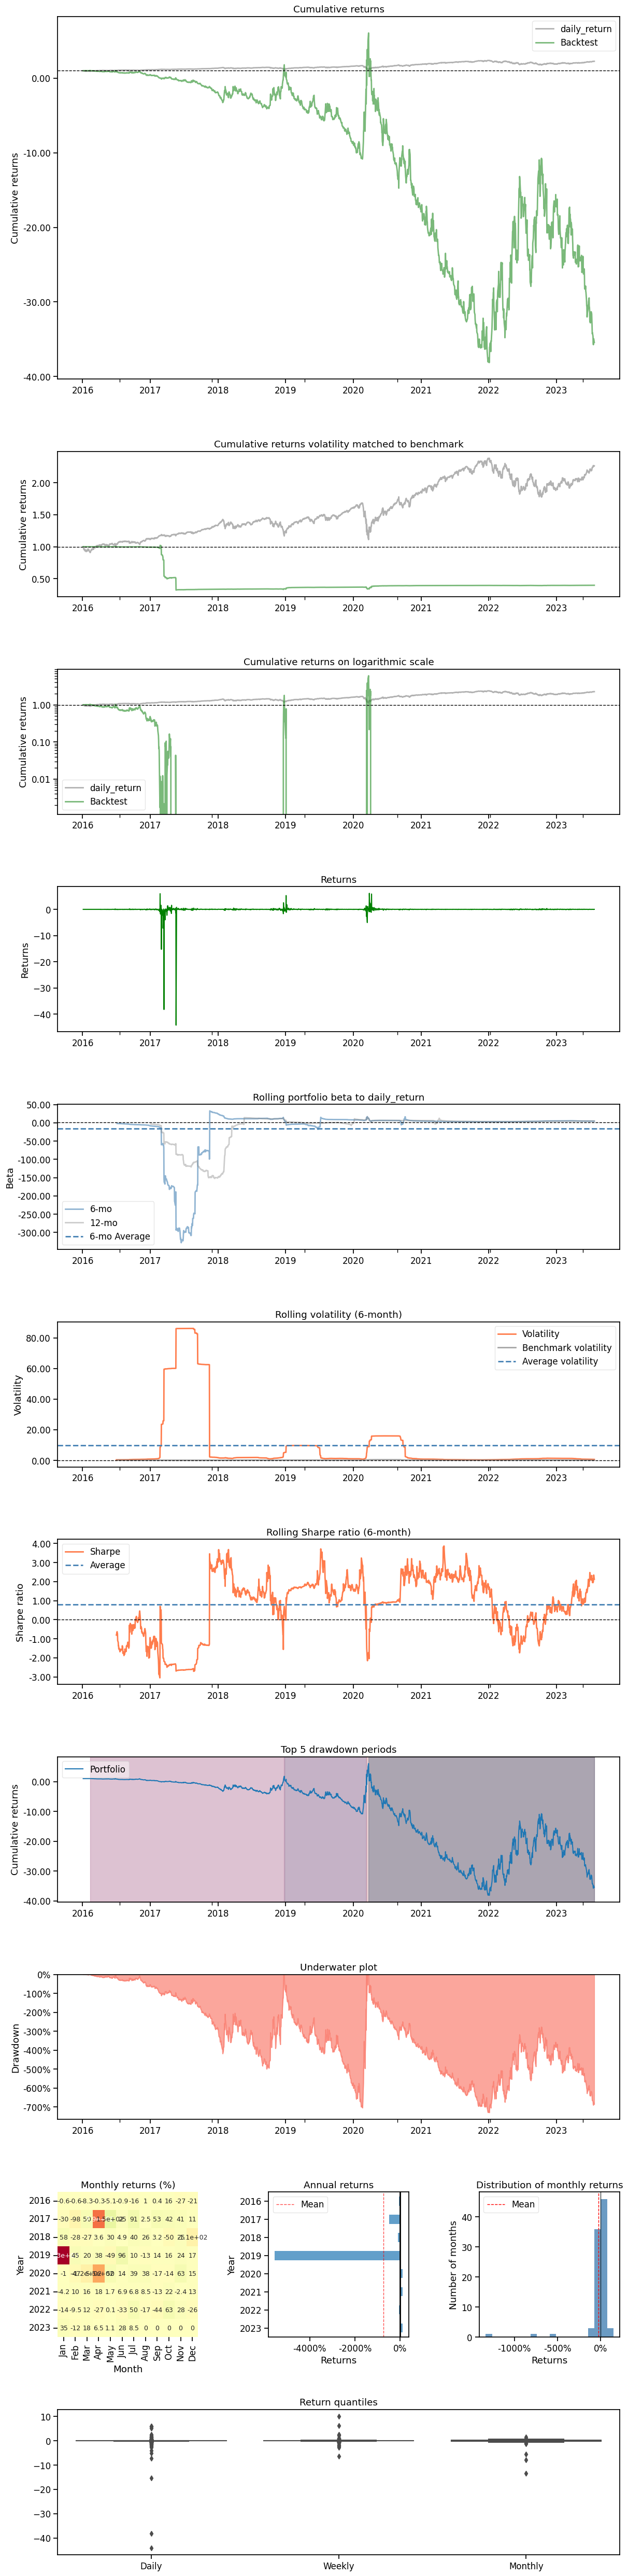

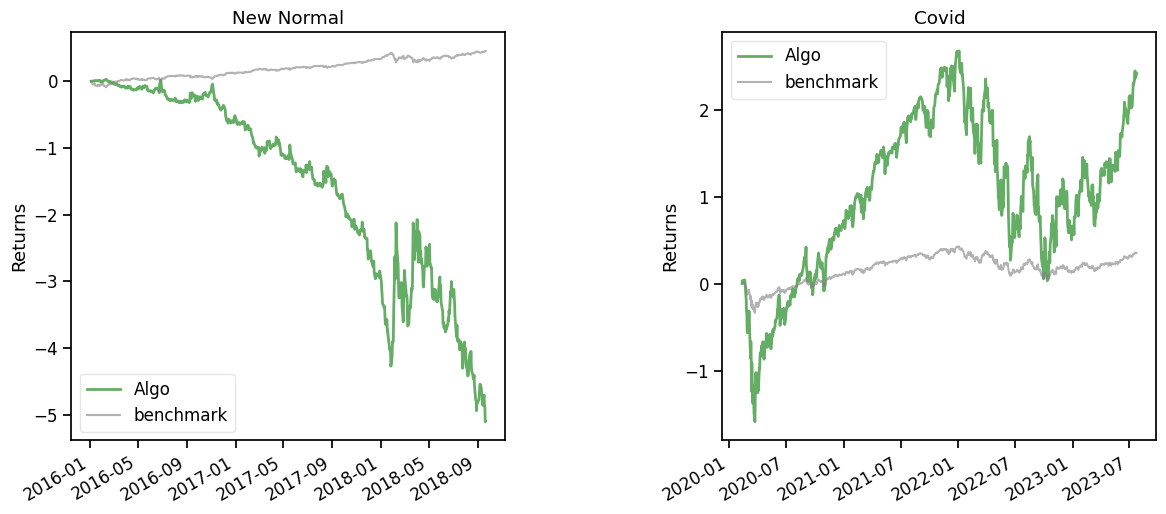

In [71]:
%matplotlib inline
baseline_df = get_baseline(
        ticker='^SPX', start=df_daily_return.loc[0,'date'], end=test_end
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
        
                                       benchmark_rets=baseline_returns, set_context=False)
